Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [22]:
from torch.utils.data import DataLoader

# Можно оставить таким
batch_size = 256

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Выбор размера батча может повлиять на сходимость процесса, что может повлиять на скорость обучения. В целом, более маленький размер батча делает обучение медленнее.

Посмотрим на какую-нибудь картинку:

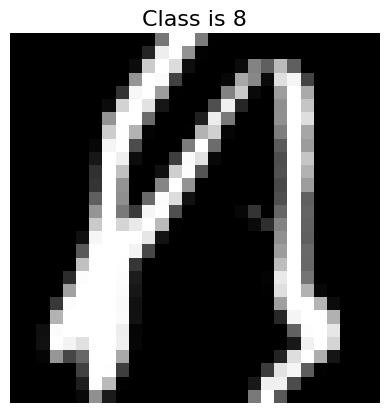

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





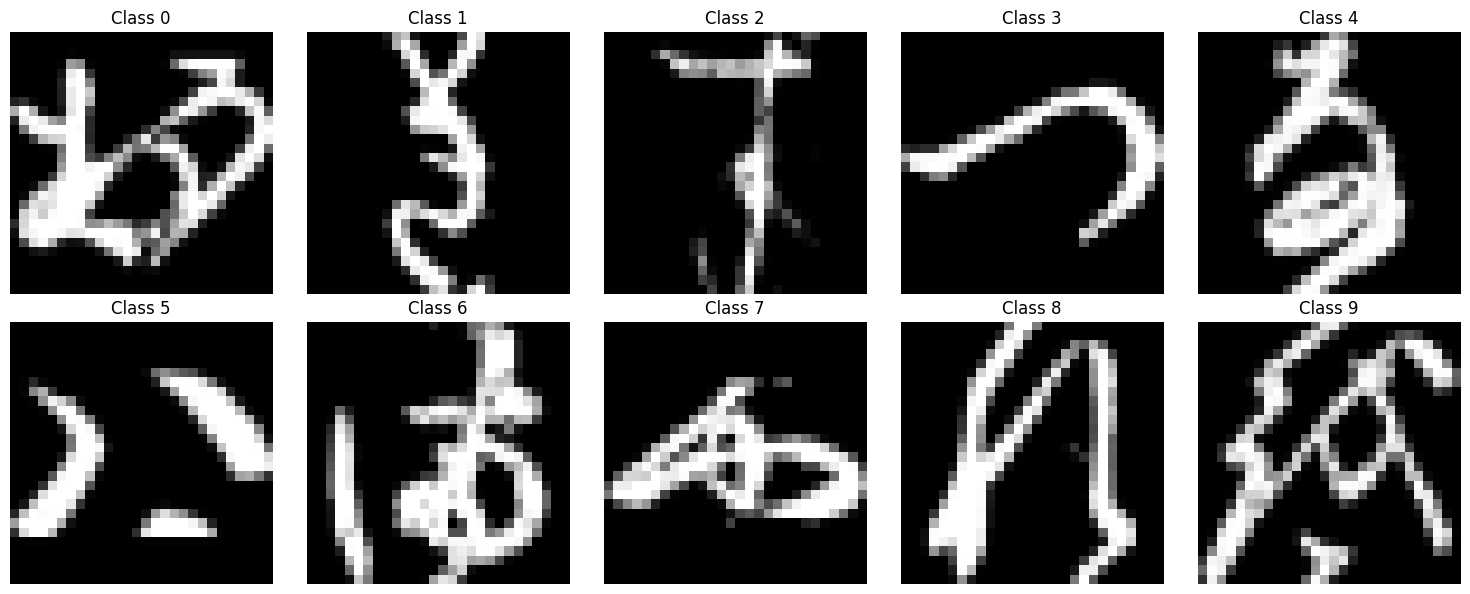

In [6]:
class_images = {i: [] for i in range(10)}

# Iterate through the dataset and store images for each class
for image, label in trainset:
    class_images[label].append(image)

# Plot images for each class
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(class_images[i][0].view(28, 28).numpy(), cmap='gray')
    axs[i].set_title(f"Class {i}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [14]:
import torch
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x



Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

1. Layer 1: Weights: 784 * 256 = 200704; Biases: 256
   
2. Layer 2: Weights: 256 * 128 = 32768; Biases: 128
   
3. Layer 3: Weights: 128 * 10 = 1280; Biases: 10

- Total weights: `200704 + 32768 + 1280 = 234752`
- Total biases: `256 + 128 + 10 = 394`

Итак, в общем модель имеет `234752` весов и `394` смещений, итого `235146` параметров.

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [15]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [16]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [17]:
n_epochs = 10
loss_history = []

train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False)
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

for epoch in range(n_epochs):
    fc_net.train()
    curr_loss = 0.0
    for im, lab in train_dataloader:
        optimizer.zero_grad()
        outputs = fc_net(im)
        loss = loss_function(outputs, lab)

        loss.backward()
        optimizer.step()

        curr_loss += loss.item()

    tr_loss = curr_loss / len(train_dataloader)
    tr_accuracy = get_accuracy(fc_net, train_dataloader)
    test_accuracy = get_accuracy(fc_net, test_dataloader)

    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {tr_loss:.4f}, "
          f"Train Accuracy: {tr_accuracy:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}")

print("Training complited!")

Epoch 1/10, Train Loss: 1.7036, Train Accuracy: 0.8255, Test Accuracy: 0.6634
Epoch 2/10, Train Loss: 1.6312, Train Accuracy: 0.8516, Test Accuracy: 0.6887
Epoch 3/10, Train Loss: 1.6080, Train Accuracy: 0.8754, Test Accuracy: 0.7070
Epoch 4/10, Train Loss: 1.5786, Train Accuracy: 0.8986, Test Accuracy: 0.7419
Epoch 5/10, Train Loss: 1.5619, Train Accuracy: 0.9128, Test Accuracy: 0.7739
Epoch 6/10, Train Loss: 1.5509, Train Accuracy: 0.9217, Test Accuracy: 0.7949
Epoch 7/10, Train Loss: 1.5430, Train Accuracy: 0.9273, Test Accuracy: 0.8013
Epoch 8/10, Train Loss: 1.5350, Train Accuracy: 0.9353, Test Accuracy: 0.8096
Epoch 9/10, Train Loss: 1.5256, Train Accuracy: 0.9443, Test Accuracy: 0.8205
Epoch 10/10, Train Loss: 1.5210, Train Accuracy: 0.9469, Test Accuracy: 0.8246
Training complited!


In [18]:
get_accuracy(fc_net, testloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.8246

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [35]:
train_data.

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./KMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [50]:
trainset.data.float().shape#.mean()

torch.Size([60000, 28, 28])

In [52]:
mean = torch.mean(trainset.data.float(), 1)#.mean()
std = torch.std(trainset.data.float(), 1)#.std()
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor([[ 0.0000,  0.0000,  1.3214,  ...,  0.0000,  0.0000,  0.0000],
        [ 7.2500, 23.6429, 32.3929,  ..., 57.6071, 46.9643, 18.7143],
        [10.7500, 53.6786, 75.6429,  ..., 57.2143, 64.7857, 33.3929],
        ...,
        [15.2500, 67.0714, 97.8571,  ..., 73.7143, 66.5000, 48.3571],
        [ 0.0000,  2.0357, 34.3929,  ..., 44.5714,  2.4286,  0.0000],
        [ 0.0000,  0.0000, 12.1429,  ..., 37.4286, 39.7857, 16.6429]]) tensor([[  0.0000,   0.0000,   4.2605,  ...,   0.0000,   0.0000,   0.0000],
        [ 26.6703,  66.9285,  76.9403,  ..., 104.3205,  95.2072,  48.5141],
        [ 33.9298,  89.0285, 106.5583,  ...,  94.2858, 105.4522,  76.8405],
        ...,
        [ 33.5864,  93.7281, 111.7218,  ..., 109.0715, 102.5878,  86.1967],
        [  0.0000,   7.7387,  73.0750,  ...,  85.8277,   7.8147,   0.0000],
        [  0.0000,   0.0000,  34.7293,  ...,  73.5892,  87.2070,  44.1825]])


In [53]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [56]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False)
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

for epoch in range(n_epochs):
    fc_net.train()
    curr_loss = 0.0
    for im, lab in train_dataloader:
        optimizer.zero_grad()
        outputs = fc_net(im)
        loss = loss_function(outputs, lab)

        loss.backward()
        optimizer.step()

        curr_loss += loss.item()

    tr_loss = curr_loss / len(train_dataloader)
    tr_accuracy = get_accuracy(fc_net, train_dataloader)
    test_accuracy = get_accuracy(fc_net, test_dataloader)

    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {tr_loss:.4f}, "
          f"Train Accuracy: {tr_accuracy:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}")

print("Training complited!")

ValueError: std evaluated to zero after conversion to torch.float32, leading to division by zero.

In [46]:
get_accuracy(fc_net, testloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.1

Как изменилась `accuracy` после нормализации?

Видимо что-то пошло не так и модель нормально не обучилась

In [57]:
# я что то запуталась....

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
## YOUR CODE HERE


In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE


In [ ]:
get_accuracy(fc_net, testloader)

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

бот не работает((

![title](./data/photo.jpg)